<a href="https://colab.research.google.com/github/terryljh/aviation2/blob/main/asrs%20linear%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
#collect all csvs in one list to read them all into one dataframe
csv_urls = [
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/jan2005-jun2005.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/jul2005-mar2006.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/april2006-november2006.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2006-august2007.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2007-may2008.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2008-february2009.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/march2009-november2009.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2009-august2010.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2010-may2011.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2011-february2012.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/march2012-november2012.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2012-august2013.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2013-may2014.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2014-april2015.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2015-january2016.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/february2016-december2016.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/january2017-november2017.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2017-october2018.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/november2018-july2019.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/august2019-may2020.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2020-april2021.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2021-apr2022.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2022-mar2023.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/apr2023-mar2024.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/apr2024-dec2025.csv']
    #this code usually takes about 15-30 seconds to read in all csv's
df = pd.concat([pd.read_csv(url) for url in csv_urls], ignore_index=True)
pd.set_option('display.max_columns', None)
new_headers = df.iloc[0] #dataset has headers, then the first row is the actual headings,
#so we want to replace headers with the first row new_headers

#removes anomolous dates that are in by mistake, should only be April 2024-May 2025

# Make the headers unique, in case some are repeated, function relabels 2,3 etc
#The ASRS occasionally has multiple reports for a single incident
#If we want to include second,third reports in our data, we need to include the
#second version of those columns too, but for simplicity maybe we only take the
#first report of each incident for now?
def make_unique(headers):
    counts = {}
    unique_headers = []
    for col in headers:
        if col in counts:
            counts[col] += 1
            unique_headers.append(f"{col}_{counts[col]}")
        else:
            counts[col] = 0
            unique_headers.append(col)
    return unique_headers
unique_headers = make_unique(new_headers)

df.columns = unique_headers
df = df.iloc[1:].reset_index(drop=True) #remove unnecessary first row

df['Date']= df['Date'].values
df['Date'] = pd.to_numeric(df['Date'], errors='coerce')
#the date column is of type string, we change to integer so we can manipulate it
#errors='coerce' will return NaN if not a number

# make normalized column from state ref column  where:
# make all upper case
# strip leading or trailing white space

df['Normalized'] = df['State Reference'].str.upper().str.strip()

#Define U.S. state abbreviations (includes DC)
us_states = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
}

#Define set of ISO alpha-2 country codes
country_codes = {
    'AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AW', 'AX', 'AZ',
    'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BL', 'BM', 'BN', 'BO', 'BQ', 'BR', 'BS', 'BT', 'BV', 'BW', 'BY', 'BZ',
    'CA', 'CC', 'CD', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CO', 'CR', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ',
    'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'EH', 'ER', 'ES', 'ET',
    'FI', 'FJ', 'FM', 'FO', 'FR','GA', 'GB', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GT', 'GU', 'GW', 'GY',
    'HK', 'HM', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IO', 'IQ', 'IR', 'IS', 'IT',
    'JE', 'JM', 'JO', 'JP','KE', 'KG', 'KH', 'KI', 'KM', 'KN', 'KP', 'KR', 'KW', 'KY', 'KZ',
    'LA', 'LB', 'LC', 'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY',
    'MA', 'MC', 'MD', 'ME', 'MF', 'MG', 'MH', 'MK', 'ML', 'MM', 'MN', 'MO', 'MP', 'MQ', 'MR', 'MS', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ',
    'NA', 'NC', 'NE', 'NF', 'NG', 'NI', 'NL', 'NO', 'NP', 'NR', 'NU', 'NZ', 'OM','PA', 'PE', 'PF', 'PG', 'PH', 'PK', 'PL', 'PM', 'PN', 'PR', 'PT', 'PW', 'PY',
    'QA', 'RE', 'RO', 'RS', 'RU', 'RW', 'SA', 'SB', 'SC', 'SD', 'SE', 'SG', 'SH', 'SI', 'SJ', 'SK', 'SL', 'SM', 'SN', 'SO', 'SR', 'SS', 'ST', 'SV', 'SX', 'SY', 'SZ',
    'TC', 'TD', 'TF', 'TG', 'TH', 'TJ', 'TK', 'TL', 'TM', 'TN', 'TO', 'TR', 'TT', 'TV', 'TZ',
    'UA', 'UG', 'UM', 'US', 'UY', 'UZ', 'VA', 'VC', 'VE', 'VG', 'VI', 'VN', 'VU', 'WF', 'WS', 'YE', 'YT', 'ZA', 'ZM', 'ZW'
}


In [25]:
#
import pandas as pd

# make a copy of cleaned data
df_cleaned = df.copy()

#  Initial classification of State, Country or 'State or Country' or Unknown
df_cleaned['Is_State'] = df_cleaned['Normalized'].isin(us_states)
df_cleaned['Is_Country'] = df_cleaned['Normalized'].isin(country_codes)
df_cleaned['Is_Ambiguous'] = df_cleaned['Is_State'] & df_cleaned['Is_Country']

def classify_abbreviation(row):
    if row['Is_Ambiguous']:
        return 'State or Country'
    elif row['Is_State']:
        return 'State'
    elif row['Is_Country']:
        return 'Country'
    else:
        return 'Unknown'

df_cleaned['Abbreviation_Type'] = df_cleaned.apply(classify_abbreviation, axis=1)

# Filter only valid 2-character abbreviations
df_cleaned['Length_Valid'] = df_cleaned['Normalized'].str.len() == 2
df_final = df_cleaned[df_cleaned['Length_Valid']].copy()

# Load airport codes from FreightPaul featured freight airport code system (IATA)
airport_codes = pd.read_csv("https://github.com/terryljh/aviation2/raw/refs/heads/main/airports.csv")

# Extract 3-letter airport code from Locale Reference
df_final.loc[:, 'Airport_Code'] = df_final['Locale Reference'].str[:3]

# Update ambiguous or unknown using airport data
needs_update = df_final['Abbreviation_Type'].isin(['Unknown', 'State or Country'])
df_to_update = df_final[needs_update].copy()

df_to_update = df_to_update.merge(
    airport_codes[['abrv', 'Code']],
    left_on='Airport_Code',
    right_on='abrv',
    how='left'
)

def resolve_from_airport(row):
    if pd.isna(row['Code']):
        return row['Abbreviation_Type']
    elif row['Code'] == 'US':
        return 'State'
    else:
        return 'Country'

df_to_update['Resolved_Type'] = df_to_update.apply(resolve_from_airport, axis=1)

# Update back into df_final
for idx, row in df_to_update.iterrows():
    df_final.loc[idx, 'Abbreviation_Type'] = row['Resolved_Type']

# Safeguard — always treat 'US' as a country
df_final.loc[df_final['Normalized'] == 'US', 'Abbreviation_Type'] = 'Country'
df_final.loc[df_final['State Reference'].str.strip().str.upper() == 'US', 'Abbreviation_Type'] = 'Country'

# apply fallback logic to any rows still ambiguous
still_uncertain = df_final['Abbreviation_Type'].isin(['State or Country', 'Unknown'])

def final_disambiguation(code):
    if code in us_states:
        return 'State'
    elif code in country_codes:
        return 'Country'
    else:
        return 'Unknown'

df_final.loc[still_uncertain, 'Abbreviation_Type'] = df_final.loc[still_uncertain, 'Normalized'].apply(final_disambiguation)

#output_path = ""C:\Users\dellx\Desktop\airport-codes.csv""
#df_final.to_csv(output_path, index=False)
#print(f" Final cleaned file saved to: {output_path}")

#print(df_final['Abbreviation_Type'].value_counts())

#there were some Canadian abbrevations that weren't in the original country codes so they were made outted to all be labeled as "Country"

# Define Canadian province abbreviations to treat as countries
canadian_provinces = {'ON', 'AB', 'BC', 'PQ', 'NB', 'MB', 'NS'}

#file_path = "C:/Users/steph/Downloads/final_state_country_with_airports.csv"
#df = pd.read_csv(file_path)

# Normalize again just in case
df_final['Normalized'] = df_final['Normalized'].str.upper().str.strip()

df_final.loc[df_final['Normalized'].isin(canadian_provinces), 'Abbreviation_Type'] = 'Country'

#df_final.to_csv(file_path, index=False)
#print(f" Updated Canadian provinces labeled as 'Country' and saved to: {file_path}")

dfsubset = df_final[['Date', 'Locale Reference', 'State Reference', 'Operating Under FAR Part','Mission','Light', 'Flight Phase','Function', 'Contributing Factors / Situations', 'Primary Problem']]
dfsubset=dfsubset.copy()
dfsubset = dfsubset[(dfsubset['Date']//100 >= 2004) & (dfsubset['Date']//100 <= 2026)]
# there are accidentally some lines where the year is 0 BC, so we remove them


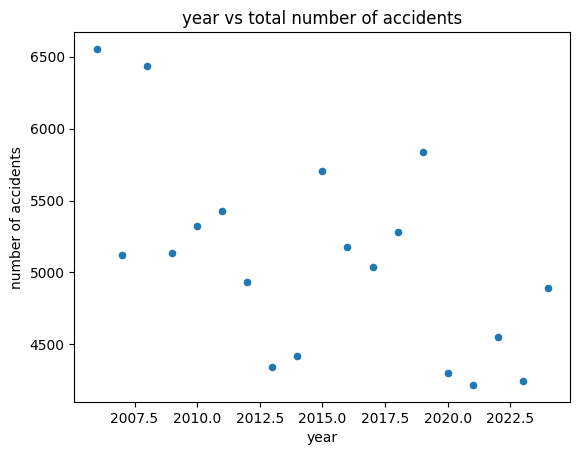

LinearRegression()

In [36]:
dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
#for the yearly counts, we cannot include 2025, because the data is not complete
#we do not include 2005 because anonymised reporting began in 2006
yearly_counts = dfsubset2.groupby(dfsubset2['Date']//100).size().reset_index(name='Accident_Count')
yearly_counts.plot.scatter(x='Date', y='Accident_Count')
plt.title('year vs total number of accidents')
plt.xlabel('year')
plt.ylabel('number of accidents')
plt.show()

from sklearn.linear_model import LinearRegression
slryearly = LinearRegression()
slryearly.fit(yearly_counts[['Date']],yearly_counts['Accident_Count'])

In [37]:
#re-doing the above with sm so we can use model summary
#decreasing trend but unreliable p-value
import statsmodels.api as sm
dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
yearly_counts = dfsubset2.groupby(dfsubset2['Date']//100).size().reset_index(name='Accident_Count')
yearly_counts.rename(columns={yearly_counts.columns[0]: 'Year'}, inplace=True)
X = sm.add_constant(yearly_counts['Year'])
y = yearly_counts['Accident_Count']
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Accident_Count   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     8.890
Date:                Sat, 07 Jun 2025   Prob (F-statistic):            0.00838
Time:                        03:24:54   Log-Likelihood:                -146.64
No. Observations:                  19   AIC:                             297.3
Df Residuals:                      17   BIC:                             299.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.498e+05   4.85e+04      3.087      0.0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [38]:
#trying monthly counts instead of yearly counts, but without distinguishing months
#shows decreasing trend but unreliable p-value
import statsmodels.api as sm

dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]

monthly_counts = dfsubset2.groupby(dfsubset2['Date']%100).size().reset_index(name='Accident_Count_Per_Month')
monthly_counts.rename(columns={monthly_counts.columns[0]: 'Month'}, inplace=True)

X = sm.add_constant(monthly_counts['Month'])
y = monthly_counts['Accident_Count_Per_Month']

model = sm.OLS(y, X).fit()

print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     Accident_Count_Per_Month   R-squared:                       0.108
Model:                                  OLS   Adj. R-squared:                  0.019
Method:                       Least Squares   F-statistic:                     1.207
Date:                      Sat, 07 Jun 2025   Prob (F-statistic):              0.298
Time:                              03:24:57   Log-Likelihood:                -90.607
No. Observations:                        12   AIC:                             185.2
Df Residuals:                            10   BIC:                             186.2
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [39]:
#add months (and possibly other things) as categorical variables
import statsmodels.api as sm

dfsubset2=dfsubset2.copy()
dfsubset2['Year'] = dfsubset2['Date']//100
dfsubset2['Month'] = dfsubset2['Date']%100

dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].astype(str).str.strip()
allowed_far_parts = ['Part 121']
dfsubset2 = dfsubset2[dfsubset2['Operating Under FAR Part'].isin(allowed_far_parts)]
#restrict to just Part 121

grouped = dfsubset2.groupby(['Year', 'Month']).size().reset_index(name='count')
month_dummies = pd.get_dummies(grouped['Month'], prefix='Month', drop_first=True)
#remove january because it is the baseline
X = pd.concat([grouped[['Year']], month_dummies], axis=1)
#y_true = dfsubset2.groupby(dfsubset2['Year','Month'].size().reset_index(name='Accident_Count'))
y_true = grouped['count']
#grouped
monthmodel = LinearRegression()
monthmodel.fit(X,y_true)

# adjusted R^2
#n = X.shape[0]  # number of samples
#p = X.shape[1]  # number of predictors (features)

#adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

#print(f"R^2: {r2:.4f}")
#print(f"Adjusted R^2: {adjusted_r2:.4f}")

#redoing above with sm so we can use model summary
import statsmodels.api as sm

dfsubset2=dfsubset2.copy()
dfsubset2['Year'] = dfsubset2['Date']//100
dfsubset2['Month'] = dfsubset2['Date']%100
grouped = dfsubset2.groupby(['Year', 'Month']).size().reset_index(name='count')
month_dummies = pd.get_dummies(grouped['Month'], prefix='Month', drop_first=True)

grouped['Year'] = pd.to_numeric(grouped['Year'], errors='coerce')
month_dummies = month_dummies.astype(float)

X = pd.concat([grouped[['Year']], month_dummies], axis=1)

X = X.dropna()
y_true = grouped.loc[X.index, 'count']

X = sm.add_constant(X, prepend=False)

monthmodel2 = sm.OLS(y_true, X).fit()
monthmodel2.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     9.025
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           5.73e-14
Time:                        03:24:59   Log-Likelihood:                -1242.1
No. Observations:                 228   AIC:                             2510.
Df Residuals:                     215   BIC:                             2555.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year          -6.7345      0.700     -9.625      0.000      -8.114      -5.355
Month_2.0    -33.6316     18.775     -1.791      0.075     -70.638       3.374
Month_3.0     -9.3158     18.775     -0.496      0.620     -46.322      27.690
Month_4.0    -18.1579     18.775     -0.967      0.335     -55.164      18.848
Month_5.0    -18.4211     18.775     -0.981      0.328     -55.427      18.585
Month_6.0     -1.5263     18.775     -0.081      0.935     -38.532      35.480
Month_7.0     27.1579     18.775      1.447      0.149      -9.848      64.164
Month_8.0      3.3684     18.775      0.179      0.858     -33.638      40.374
Month_9.0    -24.7368     18.775     -1.318      0.189     -61.743      12.269
Month_10.0   -10.0000     18.775     -0.533      0.595     -47.006      27.006
Month_11.0    -9.6842     18.775     -0.516      0.607     -46.690      27.322
Month_12.0     3.5263     18.775      0.188      0.851     -33.480      40.532
const       1.383e+04   1409.938      9.812      0.000    1.11e+04    1.66e+04
==============================================================================
Omnibus:                       21.406   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.690
Skew:                           0.572   Prob(JB):                     7.97e-08
Kurtosis:                       4.460   Cond. No.                     7.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
#adding in the four FAR parts as categorical variables increases the adjusted R^2 a lot
#even over restricting to just one FAR part 121
#so the model explains the variation well, but only because a huge amount
#of the variation is caused by the FAR part. If we want to really understand the cause
#of the accidents, I think this means we need to model each part (121, 95) individually
import statsmodels.api as sm

#dfsubset3=dfsubset2.copy()

dfsubset3 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
dfsubset3['Year'] = dfsubset3['Date']//100
dfsubset3['Month'] = dfsubset3['Date']%100
dfsubset3=dfsubset3.copy()

dfsubset3 = dfsubset3.dropna(subset=['Month', 'Operating Under FAR Part'])

dfsubset3['Operating Under FAR Part'] = dfsubset3['Operating Under FAR Part'].astype(str).str.strip()
allowed_far_parts = ['Part 91', 'Part 107','Part 135','Part 121']
dfsubset3 = dfsubset3[dfsubset3['Operating Under FAR Part'].isin(allowed_far_parts)]


dfsubset3['Year'] = dfsubset3['Date']//100
dfsubset3['Month'] = dfsubset3['Date']%100
grouped2 = dfsubset3.groupby(['Year', 'Month','Operating Under FAR Part']).size().reset_index(name='count')
grouped2['Operating Under FAR Part'] = grouped2['Operating Under FAR Part'].fillna('Missing').astype(str)
month_dummies = pd.get_dummies(grouped2['Month'], prefix='Month', drop_first=True).reset_index(drop=True)
far_dummies = pd.get_dummies(grouped2['Operating Under FAR Part'], prefix='FAR', drop_first=False).reset_index(drop=True)
far_dummies = far_dummies.drop(columns=['FAR_Part 91'])
X = pd.concat([grouped2[['Year']], month_dummies,far_dummies], axis=1)

y_true = grouped2['count']

monthmodel = LinearRegression()
monthmodel.fit(X,y_true)


import statsmodels.api as sm

grouped2['Year'] = pd.to_numeric(grouped2['Year'], errors='coerce')
month_dummies = month_dummies.astype(float)
far_dummies = far_dummies.astype(float)

X = pd.concat([grouped2[['Year']], month_dummies,far_dummies], axis=1)

X = X.dropna()
y_true = grouped2.loc[X.index, 'count']

X = sm.add_constant(X, prepend=False)

monthmodel2 = sm.OLS(y_true, X).fit()
monthmodel2.summary()




<ipython-input-44-f7ab158ccaad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsubset3['Year'] = dfsubset3['Date']//100
<ipython-input-44-f7ab158ccaad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsubset3['Month'] = dfsubset3['Date']%100


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     304.9
Date:                Sat, 07 Jun 2025   Prob (F-statistic):          3.38e-298
Time:                        03:27:59   Log-Likelihood:                -3722.5
No. Observations:                 730   AIC:                             7477.
Df Residuals:                     714   BIC:                             7550.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Year            -1.8372      0.279     -6.573      0.000      -2.386      -1.288
Month_2.0       -9.6464      7.325     -1.317      0.188     -24.028       4.735
Month_3.0        1.5831      7.325      0.216      0.829     -12.798      15.965
Month_4.0        0.4117      7.353      0.056      0.955     -14.025      14.848
Month_5.0        5.1241      7.325      0.700      0.484      -9.257      19.506
Month_6.0       10.6487      7.325      1.454      0.146      -3.733      25.030
Month_7.0       22.3811      7.353      3.044      0.002       7.945      36.818
Month_8.0       11.4356      7.325      1.561      0.119      -2.946      25.817
Month_9.0        0.0421      7.325      0.006      0.995     -14.339      14.424
Month_10.0       5.9930      7.325      0.818      0.414      -8.389      20.374
Month_11.0       1.4613      7.299      0.200      0.841     -12.869      15.792
Month_12.0       3.4774      7.299      0.476      0.634     -10.853      17.808
FAR_Part 107   -99.5436      6.818    -14.600      0.000    -112.929     -86.158
FAR_Part 121   138.6930      3.756     36.927      0.000     131.319     146.067
FAR_Part 135  -100.0614      3.756    -26.641      0.000    -107.435     -92.687
const         3815.6807    563.215      6.775      0.000    2709.924    4921.437
==============================================================================
Omnibus:                      115.442   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              546.853
Skew:                           0.624   Prob(JB):                    1.79e-119
Kurtosis:                       7.052   Cond. No.                     7.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""